In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from matplotlib import pyplot as plt
from skimage.measure import compare_ssim
from sklearn.neural_network import MLPClassifier

Rozmiary
 - zb. treningowego:  49000, 
 - zb. testowego:     21000


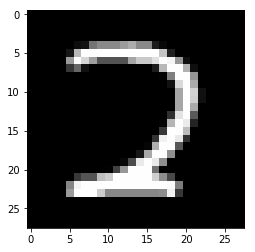

In [2]:
data = fetch_mldata('MNIST original', data_home='./data_mnist')

x, y = data['data'], data['target']

shuff = np.random.permutation(len(x))
x, y = x[shuff]/255., y[shuff]

split = int(0.7*len(x))

train_x = x[:split,:]
train_y = y[:split].reshape(-1,1)

test_x = x[split:, :]
test_y = y[split:].reshape(-1,1)
print (f'Rozmiary\n - zb. treningowego: {len(train_x): 4}, \n - zb. testowego:{len(test_x): 10}')
plt.imshow(test_x[0].reshape(28,28), cmap='gray')

In [6]:
class ELM:

    def __init__(self, d_in, d_h, d_out, activation=np.tanh):
        self.d_in = d_in
        self.d_h = d_h
        self.d_out = d_out

        self.activation = activation

        self.W_in = np.empty((d_in, d_h))
        self.bias = np.empty((1, d_h))
        self.W_out = np.empty((d_h, d_out))

    def train(self, x, y, C=0, W=None, bias = True):
        if y.shape[1] != self.d_out:
            y = self.to_categorical(y, self.d_out)
        if W is None:
            W = np.ones((len(y), 1))

        self.W_in = np.random.normal(0, 0.1,
                                     size=(self.d_in, self.d_h))
        if bias:
            self.bias = np.random.normal(0, 0.1,
                                         size=(1, self.d_h))
        else:
            self.bias = 0
        H = self.activation(x.dot(self.W_in) + self.bias)

        regul = C * np.identity(self.d_h)
        HT = H.T
        self.W_out = (np.linalg.inv(regul + HT.dot(W * H))
                      .dot(HT).dot(W * y))

    def transform(self, x):
        H = self.activation(x.dot(self.W_in) + self.bias)
        return H.dot(self.W_out)

    def predict(self, x):
        return self.transform(x).argmax(axis=1).reshape(-1,1)

    @staticmethod
    def to_categorical(y, num_classes):
        y_onehot = np.zeros((len(y), num_classes))
        for i in range(len(y)):
            y_onehot[i, int(y[i])] = 1.
        return y_onehot


# Porównanie - propagacja wsteczna

In [3]:
mlp = MLPClassifier(hidden_layer_sizes=[700], 
                    activation='tanh', 
                    alpha=0.001, verbose=True, solver='sgd',
                    max_iter=5)

In [7]:
%%time
mlp.fit(train_x, ELM.to_categorical(train_y,10))

Iteration 1, loss = 2.25727402
Iteration 2, loss = 1.34862275
Iteration 3, loss = 1.13069167
Iteration 4, loss = 1.01572695
Iteration 5, loss = 0.94221529
Wall time: 1min 16s


C:\Users\mkosturek\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[700], learning_rate='constant',
       learning_rate_init=0.001, max_iter=5, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [8]:
(mlp.predict(test_x).argmax(axis=1).reshape(-1,1)==test_y).mean()

0.7792857142857142

# Klasyfikacja

In [9]:
%%time
elm = ELM(784, 700, 10)
elm.train(train_x, train_y, C=2.3)

Wall time: 5.14 s


In [10]:
(elm.predict(test_x) == test_y).mean()

0.9210952380952381

# Autokoder

In [11]:
%%time
elm = ELM(784, 400, 784)
elm.train(train_x, train_x, C=0.3)

Wall time: 3.35 s


In [13]:
res_train = elm.transform(train_x)
res_test = elm.transform(test_x)

## Ewaluacja

In [14]:
def ssim(image1, image2):
    return compare_ssim(image1.reshape(28,28), image2.reshape(28,28))

def mean_ssim(images1, images2):
    ssims = []
    for im1, im2 in zip(images1, images2):
        ssims.append(ssim(im1, im2))
    return np.mean(ssims)

similarity: 0.13029500394819618


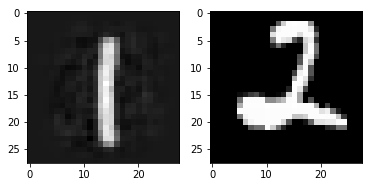

In [15]:
f, a = plt.subplots(ncols=2)
i1, i2 = 1, 2
a[0].imshow(res_test[i1].reshape(28,28), cmap='gray')
a[1].imshow(train_x[i2].reshape(28,28), cmap='gray')
print(f'similarity: {ssim(res_test[i1].reshape(28,28), train_x[i2].reshape(28,28))}')

In [16]:
print(f'Train Avg similarity: {mean_ssim(res_train, train_x)}')

Train Avg similarity: 0.843510571485311


In [17]:
print(f'Test Avg similarity: {mean_ssim(res_test, test_x)}')

Test Avg similarity: 0.8416767273744507


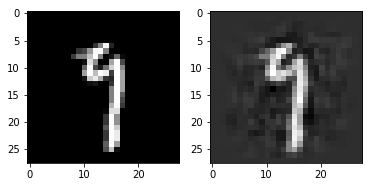

In [18]:
f, a = plt.subplots(ncols=2)
i = 120
a[0].imshow(test_x[i].reshape(28,28), cmap='gray')
a[1].imshow(res_test[i].reshape(28,28), cmap='gray')

# Z użyciem HP-ELM
http://hpelm.readthedocs.io/en/latest/

In [ ]:
import hpelm

In [ ]:
elm = hpelm.ELM(784, 10)
elm.add_neurons(3000, 'tanh')

In [ ]:
%%time
elm.train(train_x, ELM.to_categorical(train_y, 10))

In [ ]:
(elm.predict(test_x).argmax(axis=1).reshape(-1,1) == test_y).mean()

In [ ]:
helm = hpelm.HPELM(784, 10)
helm.add_neurons(3000, 'tanh')

In [ ]:
%%time
helm.train(train_x, ELM.to_categorical(train_y, 10))

In [ ]:
(helm.predict(test_x).argmax(axis=1).reshape(-1,1) == test_y).mean()